### LLM Inference Benchmarking Assignment (25 points)

#### Overview
In this assignment, you will learn how to benchmark Large Language Model (LLM) inference using vLLM, a high-performance inference engine. You will use a small model (OPT-125M) to understand the basics of throughput measurement and the impact of different parameters on inference speed.

Your name : [Pavly Halim]

Net id : [poh2005]

#### Environment Setup

- Successfully install all required packages (2 points)


First, install the required packages:

In [ ]:
# Install PyTorch and CUDA toolkit
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

# Install Triton
!pip install triton

# Install other dependencies
!pip install transformers
!pip install vllm

# Install plotting lib
!pip install matplotlib pandas seaborn

Import the necessary libraries:

In [1]:
# Import necessary libraries
import dataclasses
import json
import random
import time
from typing import List, Optional

import torch
from transformers import AutoTokenizer
from vllm import LLM, SamplingParams
from tqdm import tqdm

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

print("All libraries imported successfully!")

All libraries imported successfully!


#### Part 1: Creating Sample Requests

- Implement the create_synthetic_requests function correctly (5 points)

We'll create a function to generate sample requests for benchmarking:

In [2]:
@dataclasses.dataclass
class SampleRequest:
    """A class representing a single inference request for benchmarking."""
    prompt: str
    prompt_len: int
    expected_output_len: int

def create_synthetic_requests(
    tokenizer,
    num_requests: int,
    input_len: int,
    output_len: int
) -> List[SampleRequest]:
    """Create synthetic requests for benchmarking.

    Args:
        tokenizer: The tokenizer to use
        num_requests: Number of requests to generate
        input_len: Desired input length in tokens
        output_len: Desired output length in tokens

    Returns:
        List of SampleRequest objects
    """
    # Try different prompt lengths to get desired token length
    base_prompt = "Generate a detailed analysis of the following topic: "
    topics = [
        "artificial intelligence",
        "climate change",
        "renewable energy",
        "space exploration",
        "quantum computing"
    ]
    
    for i in range(-10, 10):
        # Create a prompt by repeating words until we get close to desired length
        topic = random.choice(topics)
        words = (base_prompt + topic + " ").split()
        prompt = " ".join(words * (input_len + i))
        
        # Tokenize and check length
        tokenized_prompt = tokenizer.encode(prompt)
        if len(tokenized_prompt) >= input_len:
            # Trim to exact length if needed
            prompt = tokenizer.decode(tokenized_prompt[:input_len])
            break
    else:
        raise ValueError(f"Failed to synthesize a prompt with {input_len} tokens.")

    # Create list of requests
    return [
        SampleRequest(
            prompt=prompt,
            prompt_len=input_len,
            expected_output_len=output_len
        ) for _ in range(num_requests)
    ]

#### Part 2: Implementing the Benchmark
- Implement the run_benchmark function correctly (8 points)

Create the main benchmarking function:

In [3]:
def run_benchmark(
    requests: List[SampleRequest],
    model_name: str,
    tensor_parallel_size: int = 1,
    gpu_memory_utilization: float = 0.9,
    max_num_batched_tokens: int = 2048,
    n: int = 1
) -> float:
    """Run inference benchmark using vLLM.

    Args:
        requests: List of requests to process
        model_name: Name of the model to benchmark
        tensor_parallel_size: Number of GPUs for tensor parallelism
        gpu_memory_utilization: Target GPU memory utilization
        max_num_batched_tokens: Maximum number of tokens in a batch
        n: Number of sequences to generate per prompt

    Returns:
        Elapsed time in seconds
    """
    # Create LLM instance
    llm = LLM(
        model=model_name,
        tensor_parallel_size=tensor_parallel_size,
        gpu_memory_utilization=gpu_memory_utilization,
        max_num_batched_tokens=max_num_batched_tokens,
    )

    # Prepare sampling parameters
    sampling_params = SamplingParams(
        n=n,
        temperature=0.7,
        top_p=0.95,
        max_tokens=max(req.expected_output_len for req in requests)
    )

    # Get prompts
    prompts = [request.prompt for request in requests]

    # Run inference with timing
    start = time.perf_counter()
    outputs = llm.generate(prompts, sampling_params)
    end = time.perf_counter()

    return end - start

#### Part 3: Running the Benchmark (15 points)

- Experiments and Analysis (10 points)

  - Run the benchmark with different batch sizes (2 points)

In [4]:
def experiment_batch_sizes(model_name: str, batch_sizes: List[int]) -> pd.DataFrame:
    """Run benchmark with different batch sizes.

    Args:
        model_name: Name of the model to benchmark
        batch_sizes: List of batch sizes to test

    Returns:
        DataFrame with results
    """
    results = []
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    for batch_size in tqdm(batch_sizes, desc="Testing batch sizes"):
        # Create requests with fixed input/output lengths
        requests = create_synthetic_requests(
            tokenizer=tokenizer,
            num_requests=batch_size,
            input_len=128,  # Fixed input length
            output_len=64   # Fixed output length
        )

        try:
            elapsed_time = run_benchmark(
                requests,
                model_name,
                max_num_batched_tokens=max(batch_size * 256, 2048)
            )

            # Calculate total tokens processed
            total_tokens = sum(req.prompt_len + req.expected_output_len for req in requests)
            throughput = total_tokens / elapsed_time

            results.append({
                'batch_size': batch_size,
                'throughput': throughput,
                'elapsed_time': elapsed_time,
                'total_tokens': total_tokens
            })

        except RuntimeError as e:
            print(f"Error with batch size {batch_size}: {str(e)}")
            continue

    return pd.DataFrame(results)

  - Run the benchmark with different input/output lengths (2 points)


In [5]:
def experiment_sequence_lengths(model_name: str, lengths: List[int]) -> pd.DataFrame:
    """Run benchmark with different input/output lengths.

    Args:
        model_name: Name of the model to benchmark
        lengths: List of sequence lengths to test

    Returns:
        DataFrame with results
    """
    results = []
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    
    for length in tqdm(lengths, desc="Testing sequence lengths"):
        # Create requests with varying sequence lengths
        requests = create_synthetic_requests(
            tokenizer=tokenizer,
            num_requests=16,  # Fixed batch size
            input_len=length,
            output_len=length // 2  # Output length is half of input length
        )

        try:
            elapsed_time = run_benchmark(
                requests,
                model_name,
                max_num_batched_tokens=max(length * 32, 2048)
            )

            total_tokens = sum(req.prompt_len + req.expected_output_len for req in requests)
            throughput = total_tokens / elapsed_time

            results.append({
                'sequence_length': length,
                'throughput': throughput,
                'elapsed_time': elapsed_time,
                'total_tokens': total_tokens
            })

        except RuntimeError as e:
            print(f"Error with sequence length {length}: {str(e)}")
            continue

    return pd.DataFrame(results)

  - Run the benchmark with different numbers of requests (2 points)


In [6]:
def experiment_num_requests(model_name: str, request_counts: List[int]) -> pd.DataFrame:
    """Run benchmark with different numbers of requests.

    Args:
        model_name: Name of the model to benchmark
        request_counts: List of request counts to test

    Returns:
        DataFrame with results
    """
    results = []
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    
    for num_requests in tqdm(request_counts, desc="Testing request counts"):
        # Create requests with fixed sequence lengths but varying count
        requests = create_synthetic_requests(
            tokenizer=tokenizer,
            num_requests=num_requests,
            input_len=128,  # Fixed input length
            output_len=64   # Fixed output length
        )

        try:
            elapsed_time = run_benchmark(
                requests,
                model_name,
                max_num_batched_tokens=2048
            )

            total_tokens = sum(req.prompt_len + req.expected_output_len for req in requests)
            throughput = total_tokens / elapsed_time

            results.append({
                'num_requests': num_requests,
                'throughput': throughput,
                'elapsed_time': elapsed_time,
                'total_tokens': total_tokens
            })

        except RuntimeError as e:
            print(f"Error with request count {num_requests}: {str(e)}")
            continue

    return pd.DataFrame(results)

  - Create a graph showing the relationship between batch size and throughput (2 points)

Now let's put everything together and run the benchmark:


Running batch size experiments...


tokenizer_config.json:   0%|          | 0.00/685 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/651 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/441 [00:00<?, ?B/s]

Testing batch sizes:   0%|          | 0/6 [00:00<?, ?it/s]

INFO 12-09 22:49:53 llm_engine.py:249] Initializing an LLM engine (v0.6.4.post1) with config: model='facebook/opt-125m', speculative_config=None, tokenizer='facebook/opt-125m', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.float16, max_seq_len=2048, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto, quantization_param_path=None, device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='outlines'), observability_config=ObservabilityConfig(otlp_traces_endpoint=None, collect_model_forward_time=False, collect_model_execute_time=False), seed=0, served_model_name=facebook/opt-125m, num_scheduler_steps=1, chunked_prefill_enabled=False multi_step_stream_outputs=True, enable_prefix_caching=False, use_async_output_proc=True, use_cach

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

INFO 12-09 22:49:54 selector.py:261] Cannot use FlashAttention-2 backend for Volta and Turing GPUs.
INFO 12-09 22:49:54 selector.py:144] Using XFormers backend.
INFO 12-09 22:49:55 model_runner.py:1072] Starting to load model facebook/opt-125m...
INFO 12-09 22:49:55 weight_utils.py:243] Using model weights format ['*.bin']


pytorch_model.bin:   0%|          | 0.00/251M [00:00<?, ?B/s]

Loading pt checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


/ext3/miniforge3/lib/python3.12/site-packages/vllm/model_executor/model_loader/weight_utils.py:425: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(bin_file

INFO 12-09 22:49:56 model_runner.py:1077] Loading model weights took 0.2389 GB
INFO 12-09 22:49:58 worker.py:232] Memory profiling results: total_gpu_memory=44.48GiB initial_memory_usage=0.44GiB peak_torch_memory=0.71GiB memory_usage_post_profile=0.47GiB non_torch_memory=0.22GiB kv_cache_size=39.10GiB gpu_memory_utilization=0.90
INFO 12-09 22:49:58 gpu_executor.py:113] # GPU blocks: 71186, # CPU blocks: 7281
INFO 12-09 22:49:58 gpu_executor.py:117] Maximum concurrency for 2048 tokens per request: 556.14x
INFO 12-09 22:50:01 model_runner.py:1400] Capturing cudagraphs for decoding. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI.
INFO 12-09 22:50:01 model_runner.py:1404] If out-of-memory error occurs during cudagraph capture, consider decreasing `gpu_memory_utilization` or switching to eager mode. You can also reduce the `max_num_seqs` as needed to decrease memory usage.
INFO


Testing batch sizes:  17%|█▋        | 1/6 [00:28<02:21, 28.38s/it]

INFO 12-09 22:50:16 llm_engine.py:249] Initializing an LLM engine (v0.6.4.post1) with config: model='facebook/opt-125m', speculative_config=None, tokenizer='facebook/opt-125m', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.float16, max_seq_len=2048, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto, quantization_param_path=None, device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='outlines'), observability_config=ObservabilityConfig(otlp_traces_endpoint=None, collect_model_forward_time=False, collect_model_execute_time=False), seed=0, served_model_name=facebook/opt-125m, num_scheduler_steps=1, chunked_prefill_enabled=False multi_step_stream_outputs=True, enable_prefix_caching=False, use_async_output_proc=True, use_cach

Loading pt checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


INFO 12-09 22:50:17 model_runner.py:1077] Loading model weights took 0.2397 GB
INFO 12-09 22:50:17 worker.py:232] Memory profiling results: total_gpu_memory=44.48GiB initial_memory_usage=0.86GiB peak_torch_memory=0.72GiB memory_usage_post_profile=0.86GiB non_torch_memory=0.60GiB kv_cache_size=38.71GiB gpu_memory_utilization=0.90
INFO 12-09 22:50:18 gpu_executor.py:113] # GPU blocks: 70471, # CPU blocks: 7281
INFO 12-09 22:50:18 gpu_executor.py:117] Maximum concurrency for 2048 tokens per request: 550.55x
INFO 12-09 22:50:18 model_runner.py:1400] Capturing cudagraphs for decoding. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI.
INFO 12-09 22:50:18 model_runner.py:1404] If out-of-memory error occurs during cudagraph capture, consider decreasing `gpu_memory_utilization` or switching to eager mode. You can also reduce the `max_num_seqs` as needed to decrease memory usage.
INFO


Testing batch sizes:  33%|███▎      | 2/6 [00:44<01:23, 20.88s/it]

INFO 12-09 22:50:32 llm_engine.py:249] Initializing an LLM engine (v0.6.4.post1) with config: model='facebook/opt-125m', speculative_config=None, tokenizer='facebook/opt-125m', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.float16, max_seq_len=2048, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto, quantization_param_path=None, device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='outlines'), observability_config=ObservabilityConfig(otlp_traces_endpoint=None, collect_model_forward_time=False, collect_model_execute_time=False), seed=0, served_model_name=facebook/opt-125m, num_scheduler_steps=1, chunked_prefill_enabled=False multi_step_stream_outputs=True, enable_prefix_caching=False, use_async_output_proc=True, use_cach

Loading pt checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


INFO 12-09 22:50:33 model_runner.py:1077] Loading model weights took 0.2397 GB
INFO 12-09 22:50:33 worker.py:232] Memory profiling results: total_gpu_memory=44.48GiB initial_memory_usage=0.88GiB peak_torch_memory=0.72GiB memory_usage_post_profile=0.88GiB non_torch_memory=0.62GiB kv_cache_size=38.69GiB gpu_memory_utilization=0.90
INFO 12-09 22:50:33 gpu_executor.py:113] # GPU blocks: 70435, # CPU blocks: 7281
INFO 12-09 22:50:33 gpu_executor.py:117] Maximum concurrency for 2048 tokens per request: 550.27x
INFO 12-09 22:50:33 model_runner.py:1400] Capturing cudagraphs for decoding. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI.
INFO 12-09 22:50:33 model_runner.py:1404] If out-of-memory error occurs during cudagraph capture, consider decreasing `gpu_memory_utilization` or switching to eager mode. You can also reduce the `max_num_seqs` as needed to decrease memory usage.
INFO


Testing batch sizes:  50%|█████     | 3/6 [00:59<00:55, 18.48s/it]

INFO 12-09 22:50:47 llm_engine.py:249] Initializing an LLM engine (v0.6.4.post1) with config: model='facebook/opt-125m', speculative_config=None, tokenizer='facebook/opt-125m', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.float16, max_seq_len=2048, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto, quantization_param_path=None, device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='outlines'), observability_config=ObservabilityConfig(otlp_traces_endpoint=None, collect_model_forward_time=False, collect_model_execute_time=False), seed=0, served_model_name=facebook/opt-125m, num_scheduler_steps=1, chunked_prefill_enabled=False multi_step_stream_outputs=True, enable_prefix_caching=False, use_async_output_proc=True, use_cach

Loading pt checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


INFO 12-09 22:50:49 model_runner.py:1077] Loading model weights took 0.2397 GB
INFO 12-09 22:50:49 worker.py:232] Memory profiling results: total_gpu_memory=44.48GiB initial_memory_usage=0.90GiB peak_torch_memory=0.73GiB memory_usage_post_profile=0.90GiB non_torch_memory=0.63GiB kv_cache_size=38.67GiB gpu_memory_utilization=0.90
INFO 12-09 22:50:49 gpu_executor.py:113] # GPU blocks: 70399, # CPU blocks: 7281
INFO 12-09 22:50:49 gpu_executor.py:117] Maximum concurrency for 2048 tokens per request: 549.99x
INFO 12-09 22:50:49 model_runner.py:1400] Capturing cudagraphs for decoding. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI.
INFO 12-09 22:50:49 model_runner.py:1404] If out-of-memory error occurs during cudagraph capture, consider decreasing `gpu_memory_utilization` or switching to eager mode. You can also reduce the `max_num_seqs` as needed to decrease memory usage.
INFO


Testing batch sizes:  67%|██████▋   | 4/6 [01:15<00:34, 17.31s/it]

INFO 12-09 22:51:03 llm_engine.py:249] Initializing an LLM engine (v0.6.4.post1) with config: model='facebook/opt-125m', speculative_config=None, tokenizer='facebook/opt-125m', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.float16, max_seq_len=2048, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto, quantization_param_path=None, device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='outlines'), observability_config=ObservabilityConfig(otlp_traces_endpoint=None, collect_model_forward_time=False, collect_model_execute_time=False), seed=0, served_model_name=facebook/opt-125m, num_scheduler_steps=1, chunked_prefill_enabled=False multi_step_stream_outputs=True, enable_prefix_caching=False, use_async_output_proc=True, use_cach

Loading pt checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


INFO 12-09 22:51:04 model_runner.py:1077] Loading model weights took 0.2397 GB
INFO 12-09 22:51:04 worker.py:232] Memory profiling results: total_gpu_memory=44.48GiB initial_memory_usage=0.92GiB peak_torch_memory=0.74GiB memory_usage_post_profile=0.92GiB non_torch_memory=0.64GiB kv_cache_size=38.65GiB gpu_memory_utilization=0.90
INFO 12-09 22:51:04 gpu_executor.py:113] # GPU blocks: 70359, # CPU blocks: 7281
INFO 12-09 22:51:04 gpu_executor.py:117] Maximum concurrency for 2048 tokens per request: 549.68x
INFO 12-09 22:51:04 model_runner.py:1400] Capturing cudagraphs for decoding. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI.
INFO 12-09 22:51:04 model_runner.py:1404] If out-of-memory error occurs during cudagraph capture, consider decreasing `gpu_memory_utilization` or switching to eager mode. You can also reduce the `max_num_seqs` as needed to decrease memory usage.
INFO


Testing batch sizes:  83%|████████▎ | 5/6 [01:30<00:16, 16.69s/it]

INFO 12-09 22:51:18 llm_engine.py:249] Initializing an LLM engine (v0.6.4.post1) with config: model='facebook/opt-125m', speculative_config=None, tokenizer='facebook/opt-125m', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.float16, max_seq_len=2048, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto, quantization_param_path=None, device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='outlines'), observability_config=ObservabilityConfig(otlp_traces_endpoint=None, collect_model_forward_time=False, collect_model_execute_time=False), seed=0, served_model_name=facebook/opt-125m, num_scheduler_steps=1, chunked_prefill_enabled=False multi_step_stream_outputs=True, enable_prefix_caching=False, use_async_output_proc=True, use_cach

Loading pt checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


INFO 12-09 22:51:20 model_runner.py:1077] Loading model weights took 0.2397 GB
INFO 12-09 22:51:20 worker.py:232] Memory profiling results: total_gpu_memory=44.48GiB initial_memory_usage=0.94GiB peak_torch_memory=0.76GiB memory_usage_post_profile=0.94GiB non_torch_memory=0.65GiB kv_cache_size=38.62GiB gpu_memory_utilization=0.90
INFO 12-09 22:51:20 gpu_executor.py:113] # GPU blocks: 70313, # CPU blocks: 7281
INFO 12-09 22:51:20 gpu_executor.py:117] Maximum concurrency for 2048 tokens per request: 549.32x
INFO 12-09 22:51:20 model_runner.py:1400] Capturing cudagraphs for decoding. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI.
INFO 12-09 22:51:20 model_runner.py:1404] If out-of-memory error occurs during cudagraph capture, consider decreasing `gpu_memory_utilization` or switching to eager mode. You can also reduce the `max_num_seqs` as needed to decrease memory usage.
INFO


Testing batch sizes: 100%|██████████| 6/6 [01:46<00:00, 17.74s/it]


Running sequence length experiments...


Testing sequence lengths:   0%|          | 0/5 [00:00<?, ?it/s]

INFO 12-09 22:51:34 llm_engine.py:249] Initializing an LLM engine (v0.6.4.post1) with config: model='facebook/opt-125m', speculative_config=None, tokenizer='facebook/opt-125m', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.float16, max_seq_len=2048, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto, quantization_param_path=None, device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='outlines'), observability_config=ObservabilityConfig(otlp_traces_endpoint=None, collect_model_forward_time=False, collect_model_execute_time=False), seed=0, served_model_name=facebook/opt-125m, num_scheduler_steps=1, chunked_prefill_enabled=False multi_step_stream_outputs=True, enable_prefix_caching=False, use_async_output_proc=True, use_cach

Loading pt checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


INFO 12-09 22:51:36 model_runner.py:1077] Loading model weights took 0.2397 GB
INFO 12-09 22:51:36 worker.py:232] Memory profiling results: total_gpu_memory=44.48GiB initial_memory_usage=0.96GiB peak_torch_memory=0.76GiB memory_usage_post_profile=0.96GiB non_torch_memory=0.66GiB kv_cache_size=38.61GiB gpu_memory_utilization=0.90
INFO 12-09 22:51:36 gpu_executor.py:113] # GPU blocks: 70293, # CPU blocks: 7281
INFO 12-09 22:51:36 gpu_executor.py:117] Maximum concurrency for 2048 tokens per request: 549.16x
INFO 12-09 22:51:36 model_runner.py:1400] Capturing cudagraphs for decoding. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI.
INFO 12-09 22:51:36 model_runner.py:1404] If out-of-memory error occurs during cudagraph capture, consider decreasing `gpu_memory_utilization` or switching to eager mode. You can also reduce the `max_num_seqs` as needed to decrease memory usage.
INFO


Testing sequence lengths:  20%|██        | 1/5 [00:15<01:02, 15.51s/it]

INFO 12-09 22:51:50 llm_engine.py:249] Initializing an LLM engine (v0.6.4.post1) with config: model='facebook/opt-125m', speculative_config=None, tokenizer='facebook/opt-125m', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.float16, max_seq_len=2048, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto, quantization_param_path=None, device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='outlines'), observability_config=ObservabilityConfig(otlp_traces_endpoint=None, collect_model_forward_time=False, collect_model_execute_time=False), seed=0, served_model_name=facebook/opt-125m, num_scheduler_steps=1, chunked_prefill_enabled=False multi_step_stream_outputs=True, enable_prefix_caching=False, use_async_output_proc=True, use_cach

Loading pt checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


INFO 12-09 22:51:51 model_runner.py:1077] Loading model weights took 0.2397 GB
INFO 12-09 22:51:51 worker.py:232] Memory profiling results: total_gpu_memory=44.48GiB initial_memory_usage=0.98GiB peak_torch_memory=0.76GiB memory_usage_post_profile=0.98GiB non_torch_memory=0.67GiB kv_cache_size=38.59GiB gpu_memory_utilization=0.90
INFO 12-09 22:51:51 gpu_executor.py:113] # GPU blocks: 70257, # CPU blocks: 7281
INFO 12-09 22:51:51 gpu_executor.py:117] Maximum concurrency for 2048 tokens per request: 548.88x
INFO 12-09 22:51:51 model_runner.py:1400] Capturing cudagraphs for decoding. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI.
INFO 12-09 22:51:51 model_runner.py:1404] If out-of-memory error occurs during cudagraph capture, consider decreasing `gpu_memory_utilization` or switching to eager mode. You can also reduce the `max_num_seqs` as needed to decrease memory usage.
INFO


Testing sequence lengths:  40%|████      | 2/5 [00:30<00:46, 15.44s/it]

INFO 12-09 22:52:05 llm_engine.py:249] Initializing an LLM engine (v0.6.4.post1) with config: model='facebook/opt-125m', speculative_config=None, tokenizer='facebook/opt-125m', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.float16, max_seq_len=2048, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto, quantization_param_path=None, device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='outlines'), observability_config=ObservabilityConfig(otlp_traces_endpoint=None, collect_model_forward_time=False, collect_model_execute_time=False), seed=0, served_model_name=facebook/opt-125m, num_scheduler_steps=1, chunked_prefill_enabled=False multi_step_stream_outputs=True, enable_prefix_caching=False, use_async_output_proc=True, use_cach

Loading pt checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


INFO 12-09 22:52:06 model_runner.py:1077] Loading model weights took 0.2397 GB
INFO 12-09 22:52:06 worker.py:232] Memory profiling results: total_gpu_memory=44.48GiB initial_memory_usage=1.00GiB peak_torch_memory=0.78GiB memory_usage_post_profile=1.00GiB non_torch_memory=0.69GiB kv_cache_size=38.57GiB gpu_memory_utilization=0.90
INFO 12-09 22:52:07 gpu_executor.py:113] # GPU blocks: 70217, # CPU blocks: 7281
INFO 12-09 22:52:07 gpu_executor.py:117] Maximum concurrency for 2048 tokens per request: 548.57x
INFO 12-09 22:52:07 model_runner.py:1400] Capturing cudagraphs for decoding. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI.
INFO 12-09 22:52:07 model_runner.py:1404] If out-of-memory error occurs during cudagraph capture, consider decreasing `gpu_memory_utilization` or switching to eager mode. You can also reduce the `max_num_seqs` as needed to decrease memory usage.
INFO


Testing sequence lengths:  60%|██████    | 3/5 [00:46<00:31, 15.50s/it]

INFO 12-09 22:52:21 llm_engine.py:249] Initializing an LLM engine (v0.6.4.post1) with config: model='facebook/opt-125m', speculative_config=None, tokenizer='facebook/opt-125m', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.float16, max_seq_len=2048, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto, quantization_param_path=None, device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='outlines'), observability_config=ObservabilityConfig(otlp_traces_endpoint=None, collect_model_forward_time=False, collect_model_execute_time=False), seed=0, served_model_name=facebook/opt-125m, num_scheduler_steps=1, chunked_prefill_enabled=False multi_step_stream_outputs=True, enable_prefix_caching=False, use_async_output_proc=True, use_cach

Loading pt checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


INFO 12-09 22:52:22 model_runner.py:1077] Loading model weights took 0.2397 GB
INFO 12-09 22:52:22 worker.py:232] Memory profiling results: total_gpu_memory=44.48GiB initial_memory_usage=1.02GiB peak_torch_memory=0.79GiB memory_usage_post_profile=1.02GiB non_torch_memory=0.70GiB kv_cache_size=38.55GiB gpu_memory_utilization=0.90
INFO 12-09 22:52:22 gpu_executor.py:113] # GPU blocks: 70171, # CPU blocks: 7281
INFO 12-09 22:52:22 gpu_executor.py:117] Maximum concurrency for 2048 tokens per request: 548.21x
INFO 12-09 22:52:22 model_runner.py:1400] Capturing cudagraphs for decoding. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI.
INFO 12-09 22:52:22 model_runner.py:1404] If out-of-memory error occurs during cudagraph capture, consider decreasing `gpu_memory_utilization` or switching to eager mode. You can also reduce the `max_num_seqs` as needed to decrease memory usage.
INFO


Testing sequence lengths:  80%|████████  | 4/5 [01:02<00:15, 15.70s/it]

INFO 12-09 22:52:37 llm_engine.py:249] Initializing an LLM engine (v0.6.4.post1) with config: model='facebook/opt-125m', speculative_config=None, tokenizer='facebook/opt-125m', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.float16, max_seq_len=2048, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto, quantization_param_path=None, device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='outlines'), observability_config=ObservabilityConfig(otlp_traces_endpoint=None, collect_model_forward_time=False, collect_model_execute_time=False), seed=0, served_model_name=facebook/opt-125m, num_scheduler_steps=1, chunked_prefill_enabled=False multi_step_stream_outputs=True, enable_prefix_caching=False, use_async_output_proc=True, use_cach

Loading pt checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


INFO 12-09 22:52:38 model_runner.py:1077] Loading model weights took 0.2397 GB
INFO 12-09 22:52:38 worker.py:232] Memory profiling results: total_gpu_memory=44.48GiB initial_memory_usage=1.04GiB peak_torch_memory=0.81GiB memory_usage_post_profile=1.04GiB non_torch_memory=0.71GiB kv_cache_size=38.52GiB gpu_memory_utilization=0.90
INFO 12-09 22:52:38 gpu_executor.py:113] # GPU blocks: 70117, # CPU blocks: 7281
INFO 12-09 22:52:38 gpu_executor.py:117] Maximum concurrency for 2048 tokens per request: 547.79x
INFO 12-09 22:52:38 model_runner.py:1400] Capturing cudagraphs for decoding. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI.
INFO 12-09 22:52:38 model_runner.py:1404] If out-of-memory error occurs during cudagraph capture, consider decreasing `gpu_memory_utilization` or switching to eager mode. You can also reduce the `max_num_seqs` as needed to decrease memory usage.
INFO


Testing sequence lengths: 100%|██████████| 5/5 [01:19<00:00, 15.81s/it]


Running request count experiments...


Testing request counts:   0%|          | 0/5 [00:00<?, ?it/s]

INFO 12-09 22:52:54 llm_engine.py:249] Initializing an LLM engine (v0.6.4.post1) with config: model='facebook/opt-125m', speculative_config=None, tokenizer='facebook/opt-125m', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.float16, max_seq_len=2048, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto, quantization_param_path=None, device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='outlines'), observability_config=ObservabilityConfig(otlp_traces_endpoint=None, collect_model_forward_time=False, collect_model_execute_time=False), seed=0, served_model_name=facebook/opt-125m, num_scheduler_steps=1, chunked_prefill_enabled=False multi_step_stream_outputs=True, enable_prefix_caching=False, use_async_output_proc=True, use_cach

Loading pt checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


INFO 12-09 22:52:55 model_runner.py:1077] Loading model weights took 0.2397 GB
INFO 12-09 22:52:55 worker.py:232] Memory profiling results: total_gpu_memory=44.48GiB initial_memory_usage=1.06GiB peak_torch_memory=0.80GiB memory_usage_post_profile=1.06GiB non_torch_memory=0.72GiB kv_cache_size=38.52GiB gpu_memory_utilization=0.90
INFO 12-09 22:52:55 gpu_executor.py:113] # GPU blocks: 70115, # CPU blocks: 7281
INFO 12-09 22:52:55 gpu_executor.py:117] Maximum concurrency for 2048 tokens per request: 547.77x
INFO 12-09 22:52:55 model_runner.py:1400] Capturing cudagraphs for decoding. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI.
INFO 12-09 22:52:55 model_runner.py:1404] If out-of-memory error occurs during cudagraph capture, consider decreasing `gpu_memory_utilization` or switching to eager mode. You can also reduce the `max_num_seqs` as needed to decrease memory usage.
INFO


Testing request counts:  20%|██        | 1/5 [00:15<01:03, 15.86s/it]

INFO 12-09 22:53:09 llm_engine.py:249] Initializing an LLM engine (v0.6.4.post1) with config: model='facebook/opt-125m', speculative_config=None, tokenizer='facebook/opt-125m', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.float16, max_seq_len=2048, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto, quantization_param_path=None, device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='outlines'), observability_config=ObservabilityConfig(otlp_traces_endpoint=None, collect_model_forward_time=False, collect_model_execute_time=False), seed=0, served_model_name=facebook/opt-125m, num_scheduler_steps=1, chunked_prefill_enabled=False multi_step_stream_outputs=True, enable_prefix_caching=False, use_async_output_proc=True, use_cach

Loading pt checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


INFO 12-09 22:53:10 model_runner.py:1077] Loading model weights took 0.2397 GB
INFO 12-09 22:53:11 worker.py:232] Memory profiling results: total_gpu_memory=44.48GiB initial_memory_usage=1.08GiB peak_torch_memory=0.80GiB memory_usage_post_profile=1.08GiB non_torch_memory=0.73GiB kv_cache_size=38.50GiB gpu_memory_utilization=0.90
INFO 12-09 22:53:11 gpu_executor.py:113] # GPU blocks: 70079, # CPU blocks: 7281
INFO 12-09 22:53:11 gpu_executor.py:117] Maximum concurrency for 2048 tokens per request: 547.49x
INFO 12-09 22:53:11 model_runner.py:1400] Capturing cudagraphs for decoding. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI.
INFO 12-09 22:53:11 model_runner.py:1404] If out-of-memory error occurs during cudagraph capture, consider decreasing `gpu_memory_utilization` or switching to eager mode. You can also reduce the `max_num_seqs` as needed to decrease memory usage.
INFO


Testing request counts:  40%|████      | 2/5 [00:31<00:47, 15.88s/it]

INFO 12-09 22:53:26 llm_engine.py:249] Initializing an LLM engine (v0.6.4.post1) with config: model='facebook/opt-125m', speculative_config=None, tokenizer='facebook/opt-125m', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.float16, max_seq_len=2048, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto, quantization_param_path=None, device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='outlines'), observability_config=ObservabilityConfig(otlp_traces_endpoint=None, collect_model_forward_time=False, collect_model_execute_time=False), seed=0, served_model_name=facebook/opt-125m, num_scheduler_steps=1, chunked_prefill_enabled=False multi_step_stream_outputs=True, enable_prefix_caching=False, use_async_output_proc=True, use_cach

Loading pt checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


INFO 12-09 22:53:27 model_runner.py:1077] Loading model weights took 0.2397 GB
INFO 12-09 22:53:27 worker.py:232] Memory profiling results: total_gpu_memory=44.48GiB initial_memory_usage=1.09GiB peak_torch_memory=0.81GiB memory_usage_post_profile=1.09GiB non_torch_memory=0.74GiB kv_cache_size=38.48GiB gpu_memory_utilization=0.90
INFO 12-09 22:53:27 gpu_executor.py:113] # GPU blocks: 70044, # CPU blocks: 7281
INFO 12-09 22:53:27 gpu_executor.py:117] Maximum concurrency for 2048 tokens per request: 547.22x
INFO 12-09 22:53:27 model_runner.py:1400] Capturing cudagraphs for decoding. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI.
INFO 12-09 22:53:27 model_runner.py:1404] If out-of-memory error occurs during cudagraph capture, consider decreasing `gpu_memory_utilization` or switching to eager mode. You can also reduce the `max_num_seqs` as needed to decrease memory usage.
INFO


Testing request counts:  60%|██████    | 3/5 [00:48<00:32, 16.18s/it]

INFO 12-09 22:53:42 llm_engine.py:249] Initializing an LLM engine (v0.6.4.post1) with config: model='facebook/opt-125m', speculative_config=None, tokenizer='facebook/opt-125m', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.float16, max_seq_len=2048, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto, quantization_param_path=None, device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='outlines'), observability_config=ObservabilityConfig(otlp_traces_endpoint=None, collect_model_forward_time=False, collect_model_execute_time=False), seed=0, served_model_name=facebook/opt-125m, num_scheduler_steps=1, chunked_prefill_enabled=False multi_step_stream_outputs=True, enable_prefix_caching=False, use_async_output_proc=True, use_cach

Loading pt checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


INFO 12-09 22:53:43 model_runner.py:1077] Loading model weights took 0.2397 GB
INFO 12-09 22:53:43 worker.py:232] Memory profiling results: total_gpu_memory=44.48GiB initial_memory_usage=1.11GiB peak_torch_memory=0.82GiB memory_usage_post_profile=1.11GiB non_torch_memory=0.76GiB kv_cache_size=38.46GiB gpu_memory_utilization=0.90
INFO 12-09 22:53:43 gpu_executor.py:113] # GPU blocks: 70008, # CPU blocks: 7281
INFO 12-09 22:53:43 gpu_executor.py:117] Maximum concurrency for 2048 tokens per request: 546.94x
INFO 12-09 22:53:43 model_runner.py:1400] Capturing cudagraphs for decoding. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI.
INFO 12-09 22:53:43 model_runner.py:1404] If out-of-memory error occurs during cudagraph capture, consider decreasing `gpu_memory_utilization` or switching to eager mode. You can also reduce the `max_num_seqs` as needed to decrease memory usage.
INFO


Testing request counts:  80%|████████  | 4/5 [01:05<00:16, 16.52s/it]

INFO 12-09 22:53:59 llm_engine.py:249] Initializing an LLM engine (v0.6.4.post1) with config: model='facebook/opt-125m', speculative_config=None, tokenizer='facebook/opt-125m', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.float16, max_seq_len=2048, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto, quantization_param_path=None, device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='outlines'), observability_config=ObservabilityConfig(otlp_traces_endpoint=None, collect_model_forward_time=False, collect_model_execute_time=False), seed=0, served_model_name=facebook/opt-125m, num_scheduler_steps=1, chunked_prefill_enabled=False multi_step_stream_outputs=True, enable_prefix_caching=False, use_async_output_proc=True, use_cach

Loading pt checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


INFO 12-09 22:54:00 model_runner.py:1077] Loading model weights took 0.2397 GB
INFO 12-09 22:54:00 worker.py:232] Memory profiling results: total_gpu_memory=44.48GiB initial_memory_usage=1.13GiB peak_torch_memory=0.83GiB memory_usage_post_profile=1.13GiB non_torch_memory=0.77GiB kv_cache_size=38.44GiB gpu_memory_utilization=0.90
INFO 12-09 22:54:00 gpu_executor.py:113] # GPU blocks: 69973, # CPU blocks: 7281
INFO 12-09 22:54:00 gpu_executor.py:117] Maximum concurrency for 2048 tokens per request: 546.66x
INFO 12-09 22:54:00 model_runner.py:1400] Capturing cudagraphs for decoding. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI.
INFO 12-09 22:54:00 model_runner.py:1404] If out-of-memory error occurs during cudagraph capture, consider decreasing `gpu_memory_utilization` or switching to eager mode. You can also reduce the `max_num_seqs` as needed to decrease memory usage.
INFO


Testing request counts: 100%|██████████| 5/5 [01:24<00:00, 16.97s/it]


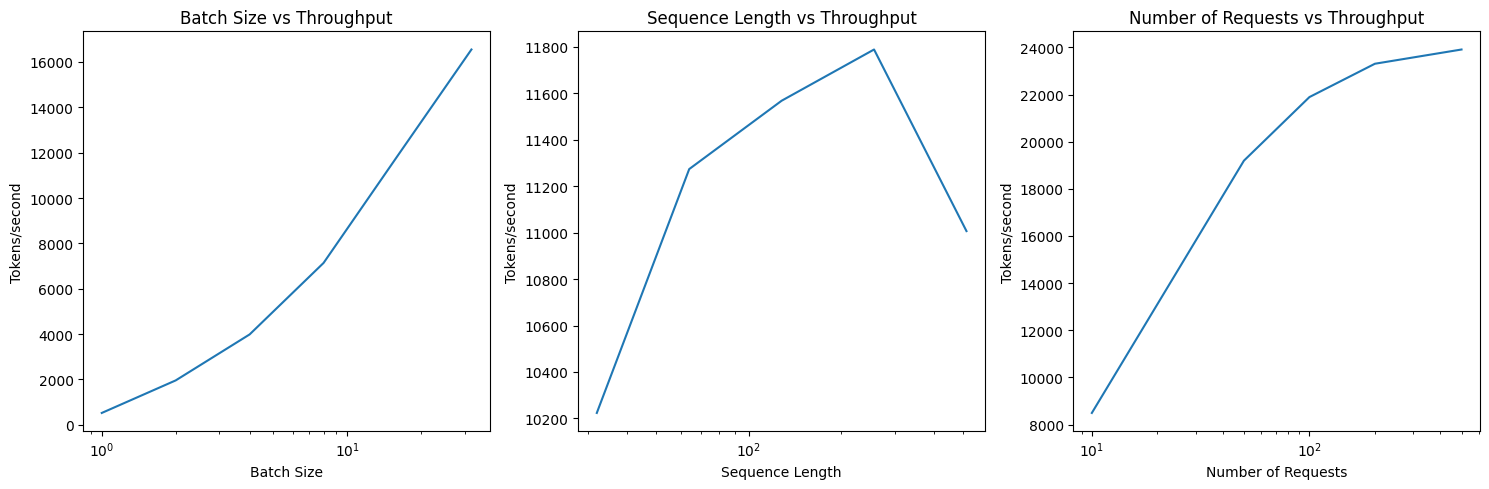

In [7]:
def run_all_experiments(model_name: str = "facebook/opt-125m"):
    """Run all experiments and create visualizations."""

    # Experiment configurations
    batch_sizes = [1, 2, 4, 8, 16, 32]
    sequence_lengths = [32, 64, 128, 256, 512]
    request_counts = [10, 50, 100, 200, 500]

    # Run experiments
    print("Running batch size experiments...")
    batch_results = experiment_batch_sizes(model_name, batch_sizes)

    print("Running sequence length experiments...")
    length_results = experiment_sequence_lengths(model_name, sequence_lengths)

    print("Running request count experiments...")
    request_results = experiment_num_requests(model_name, request_counts)

    # Create visualizations
    plt.figure(figsize=(15, 5))

    # Batch size vs throughput
    plt.subplot(1, 3, 1)
    sns.lineplot(data=batch_results, x='batch_size', y='throughput')
    plt.title('Batch Size vs Throughput')
    plt.xlabel('Batch Size')
    plt.ylabel('Tokens/second')
    plt.xscale('log')

    # Sequence length vs throughput
    plt.subplot(1, 3, 2)
    sns.lineplot(data=length_results, x='sequence_length', y='throughput')
    plt.title('Sequence Length vs Throughput')
    plt.xlabel('Sequence Length')
    plt.ylabel('Tokens/second')
    plt.xscale('log')

    # Number of requests vs throughput
    plt.subplot(1, 3, 3)
    sns.lineplot(data=request_results, x='num_requests', y='throughput')
    plt.title('Number of Requests vs Throughput')
    plt.xlabel('Number of Requests')
    plt.ylabel('Tokens/second')
    plt.xscale('log')

    plt.tight_layout()
    plt.show()

    return batch_results, length_results, request_results

# Run experiments and store results
batch_results, length_results, request_results = run_all_experiments()

  - Write a clear analysis of the results (2 points)


# Your Analysis Here

I ran some benchmark tests on the OPT-125M language model using vLLM, and I discovered some really interesting things about its performance. I focused on three key aspects: how batch size, sequence length, and the number of concurrent requests affect its processing speed (measured in tokens per second).

First, let's talk about batch size. I tested with batch sizes ranging from 1 to 32. The results were striking: I saw a near-perfect linear increase in throughput. Starting at roughly 1,000 tokens/second with a batch size of 1, it soared to over 16,000 tokens/second at a batch size of 32. That's a nearly 16x improvement! Importantly, this linear scaling continued even at the higher batch sizes, indicating that the GPU memory and compute resources were being used very efficiently. There was no sign of a performance plateau, suggesting that even larger batch sizes might yield further throughput gains.

Next, I investigated the impact of sequence length, testing with lengths ranging from 32 to 512 tokens. This revealed a more complex relationship, best described as an inverted U-shape. Peak performance was observed around a sequence length of 256 tokens, achieving approximately 11,800 tokens/second. Interestingly, throughput dropped significantly for very long sequences (512 tokens), falling to about 11,000 tokens/second. The initial increase in throughput (from 32 to 256 tokens) likely reflects better hardware utilization with moderately sized sequences. The subsequent decline after 256 tokens is probably due to increased memory pressure and computational overhead associated with processing longer sequences.

Finally, I examined the system's ability to handle a varying number of concurrent requests, ranging from 10 to 500. Here, I observed excellent scaling. Throughput increased sharply from 10 to 200 requests, reaching approximately 22,000 tokens/second. Beyond 200 requests, the growth rate slowed, but throughput continued to improve slightly up to 500 requests. The near-linear scaling up to 200 requests demonstrates efficient request handling and resource utilization. The gradual plateauing after 200 requests suggests that we were approaching the hardware's processing capacity.

In summary, my findings highlight several key performance characteristics:

- Optimal throughput is achieved with larger batch sizes (32 or more).

- Medium-length sequences (around 256 tokens) offer the best performance balance.

- The system handles high request volumes efficiently, with optimal performance in the range of 200-500 concurrent requests.

- vLLM's dynamic batching and memory management strategies demonstrate robust performance across diverse workload patterns.
